# Fine-tune pre-trained model with custom data

In [20]:
from fastai_old.text import *
import html
import spacy 

spacy.load('en')

We're going to grab our custom style text data, e.g. the text of Alice in Wonderland, from the directory `data_style/`. This data tends to be small, so it's included in the repository. We will also create a directory in which we'll store our trained language models, `data_inf/custom_lm/`. This isn't included in the repository because it can be very large.

When we create the language model, we give it a path (in this case `data_inf/custom_lm/`). Then when we save the language model, it saves the data in `path/models/`. 

Note that we'll need to load two files to load the pre-trained data model. These should be located in `data_inf/pretrained/`. The files are `fwd_wt103.h5` and `itos_wt103.pkl`.

Finally, we'll set up a master name for this fine-tuning. The vocab and model will be saved with this name. The default here is `alice`.

In [143]:
DATA_PATH=Path('data_style/')
DATA_PATH.mkdir(exist_ok=True)

LM_PATH = Path('data_inf/custom_lm/')
LM_PATH.mkdir(exist_ok=True)

PRE_PATH=Path('data_inf/pretrained/')
PRE_PATH.mkdir(exist_ok=True)

NAME = 'dfw_lobster'
ID = ''

Now we're going to load data that is a single text file of plain text. We'll need to split the text into chunks for efficient training and to hold out some data as validation. We'll set a minimum chunk size, and otherwise break at paragraphs.




In [144]:
minwords = 100

def get_texts(fname):
    texts = []
    with fname.open('r', encoding='utf-8') as f:
        curr = ['', 0]
        for line in f:
            l = len(line.split(' '))
            if curr[1] + l > minwords:
                texts.append(curr[0])
                curr = [line, l]
            else:
                curr[0] += '\n' + line
                curr[1] += l
    if curr[0] != '':
        texts.append(curr[0])
    return np.array(texts)

data_file = NAME + '.txt'
all_texts = get_texts(DATA_PATH/data_file)
len(all_texts)

54

In [146]:
random.choice(all_texts)

"There happen to be two main criteria that most ethicists agree on for determining whether a living creature has the capacity to suffer and so has genuine interests that it may or may not be our moral duty to consider[16]. One is how much of the neurological hardware required for pain-experience the animal comes equipped with—nociceptors, prostaglandins, neuronal opioid receptors, etc. The other criterion is whether the animal demonstrates behavior associated with pain. And it takes a lot of intellectual gymnastics and behaviorist hairsplitting not to see struggling, thrashing, and lid-clattering as just such pain-behavior. According to marine zoologists, it usually takes lobsters between 35 and 45 seconds to die in boiling water. (No source I could find talked about how long it takes them to die in superheated steam; one rather hopes it's faster.)\n"

Now we'll split the data into training and validation data. 


In [147]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    all_texts, test_size=0.3)

# trn_texts = all_texts
# val_texts = all_texts

len(trn_texts), len(val_texts)

(37, 17)

Using the pandas DataFrame speeds up pre-processing, though it does feel a little like overkill.

In [148]:
col_names = ['text']
df_trn = pd.DataFrame({'text':trn_texts}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts}, columns=col_names)

re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ').replace('.',' .').replace('?',' ?').replace('!',' !').replace('’'," '")
    return re1.sub(' ', html.unescape(x))

def get_texts(df):
#     texts = f'\n{BOS} {FLD} 1 ' + df['text'].astype(str)
    texts = df['text'].astype(str)
    texts = list(texts.apply(fixup).values)
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok

tok_trn = get_texts(df_trn)
tok_val = get_texts(df_val)

print(len(tok_trn), len(tok_val))

' '.join(tok_trn[0])

37 17


"\n\n these last couple queries , though , while sincere , obviously involve much larger and more abstract questions about the connections ( if any ) between aesthetics and morality , and these questions lead straightaway into such deep and treacherous waters that it 's probably best to stop the public discussion right here . there are limits to what even interested persons can ask of each other . \n\n\n\n\n"

In [149]:
freq = Counter(p for o in tok_trn for p in o)

max_vocab = 60000
min_freq = 1

itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

# itos = list(set(itos).union(itos2))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})

trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

itos_file = 'itos_' + NAME + ID + '.pkl'
with open(LM_PATH/itos_file, 'wb') as f:
    pickle.dump(itos, f)

vs=len(itos)
vs

445

In [150]:
em_sz,nh,nl = 400,1150,3

PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):                     # for word in imbd vocab
    r = stoi2[w]                                # get the int in the pretrained vocab
    new_w[i] = enc_wgts[r] if r>=0 else row_m   # add weight if in vocab, else add mean weight
    
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(LM_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.model.load_state_dict(wgts)
PRE_LM_PATH

PosixPath('data_inf/pretrained/fwd_wt103.h5')

Now we are in language modeling black magic land, following along with the fast.ai IMDB tutorial. They say to tune the last layer for one epoch first.

In [151]:
learner.metrics = [accuracy]
learner.freeze_to(-1)

lr = 1e-3
lrs = lr

learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

lm_name = NAME + ID + '_lm_last_ft'
learner.save(lm_name)

ZeroDivisionError: division by zero

And now we're going to fine-tune the whole model. First we're going to find a good learning rate, then unfreeze the whole thing (I think...) and fine-tune.



In [142]:
num_epochs = 30
learner.unfreeze()
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=num_epochs)
lm_name = NAME + ID + '_lm_' + str(num_epochs) + 'epochs'
learner.save(lm_name)

epoch      trn_loss   val_loss   accuracy               
    0      6.538502   5.285504   0.132173  



epoch      trn_loss   val_loss   accuracy               
    0      7.450596   7.146491   0.131741  
    1      6.650265   5.124443   0.1327                 
    2      6.149107   4.990943   0.132334               
    3      5.889668   4.987461   0.132837               
    4      5.731889   4.991956   0.132447               
    5      5.627389   4.993379   0.07372                
    6      5.552319   4.986248   0.132454               
    7      5.498958   4.986125   0.132233               
    8      5.45754    4.985262   0.132771               
    9      5.426917   4.987929   0.133198               
    10     5.400863   4.986519   0.132261               
    11     5.378725   4.985103   0.132261               
    12     5.362215   4.999494   0.067318               
    13     5.34766    4.974815   0.133097               
    14     5.334802   4.982419   0.132261               
    15     5.324332   4.981581   0.132956               
    16     5.315453   4.985349   0.132496   

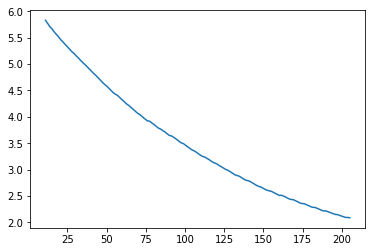

In [133]:
learner.sched.plot_loss()

In [62]:
lm_name

'alice_nop_lm_30epochs'

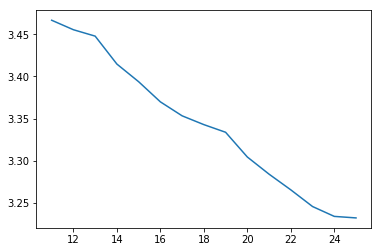

In [42]:
learner.sched.plot_loss()

In [43]:
num_epochs3 = 5
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=num_epochs3)
lm_name = NAME + ID + '_lm_' + str(num_epochs + num_epochs2 + num_epochs3) + 'epochs'

epoch      trn_loss   val_loss   accuracy               
    0      2.888924   3.50002    0.298501  
    1      2.860994   3.433103   0.313989               
    2      2.748627   3.436389   0.315063               
    3      2.686392   3.442739   0.319281               
    4      2.616784   3.44484    0.318022               



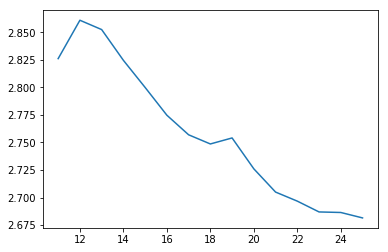

In [44]:
learner.sched.plot_loss()

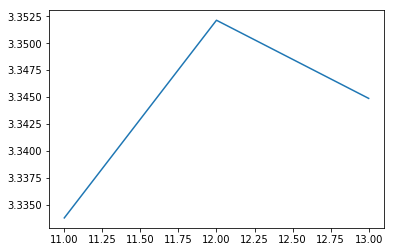

In [19]:
learner.save('alice1_lm_6epochs')
